## Импорт библиотек и константы

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from rectools import Columns

## Загрузка данных

In [4]:
interactions_df = pd.read_csv("new_data/base_models_data.csv")

In [5]:
items_df = pd.read_csv("new_data/item_features_data.csv")

In [6]:
users_df = pd.read_csv("new_data/user_features_data.csv")

In [7]:
with open("new_data/item_features_mapping.json", "r", encoding="utf-8") as f:
    item_features_mapping = json.load(f)

In [36]:
item_features_inv_mapping = dict()
for key in item_features_mapping:
    item_features_inv_mapping[key] = dict()
    for (value, label) in item_features_mapping[key].items():
        item_features_inv_mapping[key][label] = value

## Генерация новых фичей

### Фичи с семинара

In [8]:
# Длина истории юзера
interactions_df["user_history"] = (
    interactions_df.groupby(Columns.User)
    [Columns.Item].transform("count")
)

# Популярность айтем
interactions_df["item_popularity"] = (
    interactions_df.groupby(Columns.Item)
    [Columns.User].transform("count")
)

# Средняя популярность айтемов юзера
interactions_df['user_avg_popularity'] = (
    interactions_df.groupby(Columns.User)
    ['item_popularity'].transform('mean')
)

# Средняя длина истории пользователей, смотревших айтем
interactions_df['item_avg_history'] = (
    interactions_df.groupby('item_id')
    ['user_history'].transform('mean')
)

# Популярность последнего просмотренного контента
interactions_df.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)

interactions_df['user_last_popularity'] = (
    interactions_df.groupby('user_id')
    ['item_popularity'].transform('first')
)

### Придуманные фичи

#### Доля сериалов в пользовательской истории

In [9]:
# Может каким-то пользователям заходят только сериалы или они наоборот терпеть не могуn сериалы
# Доля сериалов у юзера
serials = items_df[items_df["content_type"] != 0][Columns.Item].values # 0 - код категории "фильм"
interactions_df["is_serial"] = interactions_df["item_id"].isin(serials)

group_df = (
    interactions_df
    .groupby(["user_id", "is_serial"])
    ["item_id"].count()
    .reset_index()
)

group_df = group_df.merge(
    group_df, 
    left_on='user_id', 
    right_on='user_id',
    suffixes=('_left', '_right')
)

users_watched_films_and_serials_df = (
    group_df
    [(group_df["is_serial_left"] == True) & (group_df["is_serial_right"] == False)]
    .rename({"item_id_left": "serials_count", "item_id_right": "films_count"}, axis=1)
    [["user_id", "serials_count", "films_count"]]
)

users_watched_only_one = (
    group_df
    [~group_df["user_id"].isin(users_watched_films_and_serials_df["user_id"].unique())]
    ["user_id"].unique()
)
users_watched_only_serials_df = (
    group_df
    [(group_df["user_id"].isin(users_watched_only_one)) & (group_df["is_serial_left"] == True)]
    .rename({"item_id_left": "serials_count"}, axis=1)
    [["user_id", "serials_count"]]
)
users_watched_only_serials_df["films_count"] = 0

users_watched_only_films_df = (
    group_df
    [(group_df["user_id"].isin(users_watched_only_one)) & (group_df["is_serial_left"] == False)]
    .rename({"item_id_left": "films_count"}, axis=1)
    [["user_id", "films_count"]]
)
users_watched_only_films_df["serials_count"] = 0

users_items_count_df = pd.concat([users_watched_films_and_serials_df, users_watched_only_serials_df, users_watched_only_films_df], ignore_index=True)
users_items_count_df["all_count"] = users_items_count_df["films_count"] + users_items_count_df["serials_count"]
users_items_count_df["serials_part"] = users_items_count_df["serials_count"] / users_items_count_df["all_count"]
users_items_count_df.drop_duplicates(["user_id"], inplace=True)
users_items_count_df.drop(["all_count"], axis=1, inplace=True)

In [10]:
users_items_count_df.head()

,user_id,serials_count,films_count,serials_part
0,0,3,3,0.500000
1,10,1,2,0.333333
2,11,7,5,0.583333
3,13,2,11,0.153846
4,15,5,3,0.625000


Проверим, что никого не потеряли

In [11]:
interactions_df["user_id"].nunique() == len(users_items_count_df)

True

### Количество актеров в фильме

Обычно в секции "актеры" указаны наиболее известные, чтобы привлечь пользователя к просмотру, поэтому стоит учесть количество именитых

In [12]:
items_df["actors_count"] = items_df["actors"].apply(lambda string: len(string.split(", ")))

array([[<Axes: title={'center': 'actors_count'}>]], dtype=object)

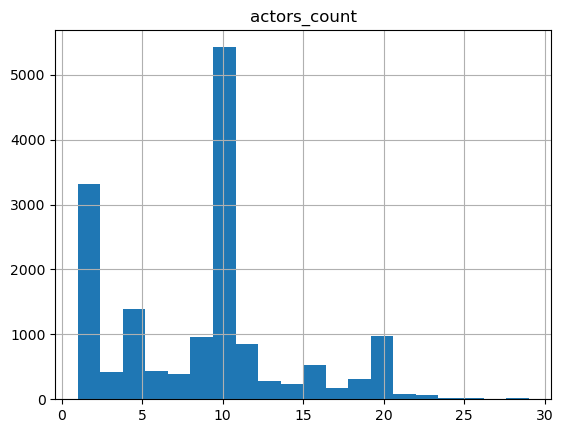

In [13]:
items_df[items_df["actors_count"] < 30].hist(column=["actors_count"], bins=20)

### Длина описания

In [14]:
items_df["description_len"] = items_df["description"].apply(lambda description: len(description))

<Axes: >

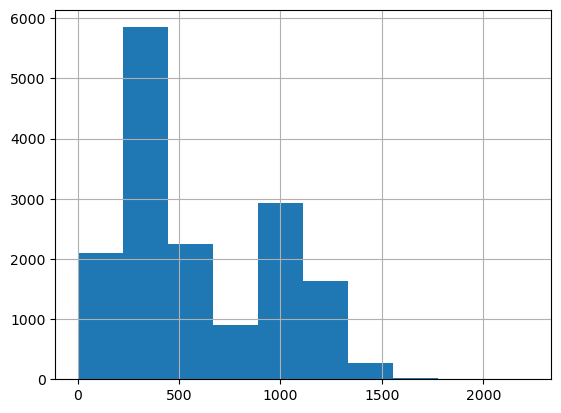

In [15]:
items_df["description_len"].hist()

### Любимый жанр юзера

Будем считать, что любимый жанр это самый распространенный жанр среди фильмов, которые пользователь досмотрел до 30%

In [16]:
interactions_with_genres = pd.merge(
    left = interactions_df[interactions_df["weight"] > 30][["user_id", "item_id", "weight"]],
    right = items_df[["item_id", "genres"]],
    on = "item_id"
)

interactions_with_genres["genre"] = interactions_with_genres["genres"].apply(lambda x: x.split(", "))

In [17]:
users_with_genres = (
    interactions_with_genres
    .explode(["genre"])
    .reset_index(drop=True)
    .groupby(["user_id", "genre"])
    ["item_id"].count()
    .reset_index()
    .sort_values(by=["user_id", "item_id"], ascending=[True, False])
    .drop_duplicates(["user_id"], keep="first")
    .rename({"item_id": "items_count", "genre": "favorite_genre"}, axis=1)
)

In [18]:
users_with_genres.head()

,user_id,favorite_genre,items_count
7,2,мультфильм,31
16,4,драмы,1
19,11,драмы,4
29,13,триллеры,3
31,14,детективы,1


<Axes: >

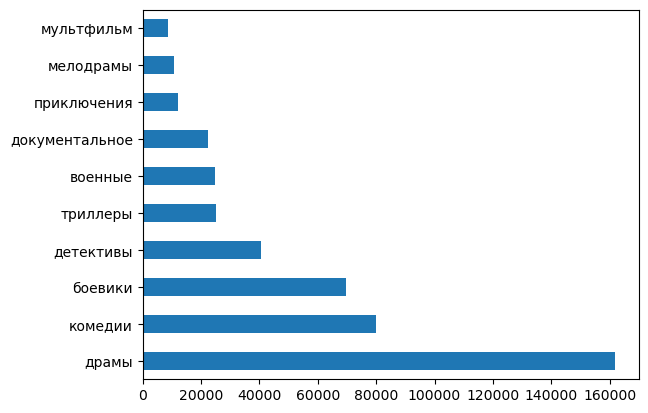

In [19]:
users_with_genres["favorite_genre"].value_counts()[:10].plot(kind="barh")

Видно, что Россия для грустных)
Но на самом деле почти в половине фильмов указан жанр "драмы"

In [20]:
items_df["genres"].apply(lambda x: "Драма в жанрах" if 'драмы' in x else "Нет драмы в жанрах").value_counts()

Нет драмы в жанрах    8827
Драма в жанрах        7136
Name: genres, dtype: int64

### Принадлежность к определенной стране

Не будем порождать большое количество признаков с помощью One Hot Encoding, вместо этого выберем три страны, по которым чаще всего (по субъективному мнению) называют фильмы или сериалы

In [21]:
items_df["american"] = items_df["countries"].apply(lambda countries: 'сша' in countries)
items_df["russian"] = items_df["countries"].apply(lambda countries: 'россия' in countries)
items_df["soviet"] = items_df["countries"].apply(lambda countries: 'ссср' in countries)

In [22]:
items_df["american"].apply(lambda flag: "Американских фильмов" if flag else "Других фильмов").value_counts(ascending=True)

Американских фильмов     5065
Других фильмов          10898
Name: american, dtype: int64

In [23]:
items_df["russian"].apply(lambda flag: "Российских фильмов" if flag else "Других фильмов").value_counts(ascending=True)

Российских фильмов     4377
Других фильмов        11586
Name: russian, dtype: int64

In [24]:
items_df["soviet"].apply(lambda flag: "Советских фильмов" if flag else "Других фильмов").value_counts(ascending=True)

Советских фильмов     1417
Других фильмов       14546
Name: soviet, dtype: int64

## Добавление полученных признаков в датафреймы юзеров и айтемов

### Юзеры

In [25]:
users_df = pd.merge(
    left=users_df, 
    right=(
        interactions_df
        [['user_id', 'user_history', 'user_avg_popularity', 'user_last_popularity']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)

In [26]:
users_df = pd.merge(
    left=users_df, 
    right=users_items_count_df,
    how='left',
    on='user_id',
)

In [27]:
users_df = pd.merge(
    left=users_df, 
    right=users_with_genres[["user_id", "favorite_genre"]],
    how='left',
    on='user_id',
)

In [28]:
users_df.head()

,user_id,age,income,sex,kids_flg,user_history,user_avg_popularity,user_last_popularity,serials_count,films_count,serials_part,favorite_genre
0,973171,1,4,1,1,5.0,19316.800000,92281.0,2.0,3.0,0.400000,драмы
1,962099,0,2,1,0,13.0,1308.307692,256.0,6.0,7.0,0.461538,боевики
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,721985,3,2,0,0,13.0,5914.307692,443.0,0.0,13.0,0.000000,драмы
4,704055,2,4,0,0,7.0,526.428571,67.0,0.0,7.0,0.000000,детективы


### Айтемы

In [29]:
items_df = pd.merge(
    left=items_df, 
    right=(
        interactions_df
        [['item_id', 'item_popularity', 'item_avg_history']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

In [30]:
items_df = items_df[[
    "item_id", "content_type", "release_year_cat", "for_kids", "age_rating", "genres", 
    "actors_count", "description_len", "american", "russian", "soviet", "item_popularity", "item_avg_history"
]]

In [31]:
items_df.head()

,item_id,content_type,release_year_cat,for_kids,age_rating,genres,actors_count,description_len,american,russian,soviet,item_popularity,item_avg_history
0,10711,0,8,0,3,"детективы, драмы, зарубежные, мелодрамы",20,956,False,False,False,NaN,NaN
1,2508,0,9,0,3,"зарубежные, комедии, приключения",20,1036,True,False,False,NaN,NaN
2,10716,0,9,0,3,"боевики, зарубежные, комедии, криминал, триллеры",14,1034,False,False,False,NaN,NaN
3,7868,0,9,0,3,"драмы, зарубежные, мелодрамы",20,997,False,False,False,NaN,NaN
4,16268,0,5,1,2,"драмы, мелодрамы, советские, спорт",20,1352,False,False,True,NaN,NaN


## Получение дефолтных значений для заполнения пропусков

В данных образовалось довольно много пропусков

In [32]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840197 entries, 0 to 840196
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               840197 non-null  int64  
 1   age                   840197 non-null  int64  
 2   income                840197 non-null  int64  
 3   sex                   840197 non-null  int64  
 4   kids_flg              840197 non-null  int64  
 5   user_history          558404 non-null  float64
 6   user_avg_popularity   558404 non-null  float64
 7   user_last_popularity  558404 non-null  float64
 8   serials_count         558404 non-null  float64
 9   films_count           558404 non-null  float64
 10  serials_part          558404 non-null  float64
 11  favorite_genre        375563 non-null  object 
dtypes: float64(6), int64(5), object(1)
memory usage: 83.3+ MB


In [38]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 0 to 15962
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_id           15963 non-null  int64  
 1   content_type      15963 non-null  int64  
 2   release_year_cat  15963 non-null  int64  
 3   for_kids          15963 non-null  int64  
 4   age_rating        15963 non-null  int64  
 5   genres            15963 non-null  object 
 6   actors_count      15963 non-null  int64  
 7   description_len   15963 non-null  int64  
 8   american          15963 non-null  bool   
 9   russian           15963 non-null  bool   
 10  soviet            15963 non-null  bool   
 11  item_popularity   6014 non-null   float64
 12  item_avg_history  6014 non-null   float64
dtypes: bool(3), float64(2), int64(7), object(1)
memory usage: 1.4+ MB


В семинарском коде медиана по признаку считалась на основе датафрейма с интеракциями. Я думаю, что корректней считать на датафрейме с юзерами или айтемами, чтобы значения не были смещенными из-за количества интеракций.

In [39]:
print("Медиана на айтемах", items_df['item_popularity'].median())
print("Медиана на интеракциях", interactions_df['item_popularity'].median())

Медиана на айтемах 124.0
Медиана на интеракциях 2859.0


In [58]:
serials_count = float(users_df["serials_count"].median())
films_count = float(users_df["films_count"].median())

users_default_values = {
    "user_history": serials_count + films_count,
    "user_avg_popularity": float(users_df["user_avg_popularity"].median()),
    "user_last_popularity": float(users_df["user_last_popularity"].median()),
    "serials_count": serials_count,
    "films_count": films_count,
    "serials_part": serials_count / (serials_count + films_count),
    "favorite_genre": users_df["favorite_genre"].mode().values[0]
}

users_df = users_df.fillna(users_default_values)

In [59]:
items_default_values = {
    "item_popularity": float(items_df["item_popularity"].median()),
    "item_avg_history": float(items_df["item_avg_history"].median())
}

items_df = items_df.fillna(items_default_values)

## Сохранение данных

In [60]:
items_df.to_csv("new_data/item_new_features_data.csv", index=False)

In [61]:
users_df.to_csv("new_data/user_new_features_data.csv", index=False)

In [64]:
with open("new_data/users_default_values.json", "w", encoding="utf-8") as f:
    json.dump(users_default_values, f)

In [65]:
with open("new_data/items_default_values.json", "w", encoding="utf-8") as f:
    json.dump(items_default_values, f)